In [1]:
import os
from collections import OrderedDict
import logging
from functools import partial

import numpy as np
from astropy.table import Table

import proxmin
import deblender

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

logger = logging.getLogger("deblender")
logger.setLevel(logging.INFO)
logger2 = logging.getLogger("proxmin")
logger2.setLevel(logging.INFO)

In [2]:
# Load the data
data = np.load("../data/test1/images.npy")
mask = np.load("../data/test1/mask.npy")
variance = np.load("../data/test1/variance.npy")
psfs = np.load("../data/test1/psfs.npy")
simTable= Table.read("../data/test1/sim.fits")
all_peaks = np.load("../data/test1/peaks.npy")
bboxes = np.load("../data/test1/bboxes.npy")

(0, 69)

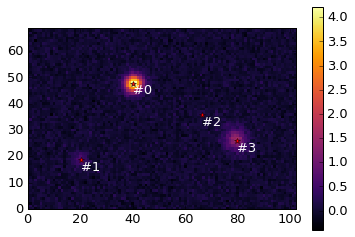

In [3]:
#parents = np.array([len(peaks)>1 for peaks in all_peaks])
parents = np.array([len(peaks)==4 for peaks in all_peaks])
bbox = bboxes[parents][0]
peaks = np.array(list(all_peaks[parents][0]))
# get the peak positions in image coordinates
np.random.seed(1)
img_peaks = np.zeros_like(peaks, dtype=float)
k = len(peaks)
img_peaks[:,0] = peaks[:,0]-bbox[2]+np.random.rand(k)-.5
img_peaks[:,1] = peaks[:,1]-bbox[0]+np.random.rand(k)-.5
img = data[:,bbox[0]:bbox[1], bbox[2]:bbox[3]]
weights = variance[:,bbox[0]:bbox[1], bbox[2]:bbox[3]]
plt.imshow(img[0])
plt.colorbar()
plt.plot(img_peaks[:,0], img_peaks[:,1], 'r*')
for i in range(len(peaks)):
    plt.text(img_peaks[i,0], img_peaks[i,1], '#%d' %i, va='top', ha='left', color='w')
plt.xlim([0,img[0].shape[1]-1])
plt.ylim([0, img[0].shape[0]-1])

In [4]:
l0_thresh=5e-4
l1_thresh = None
strict_constraints = "m"
peaks = img_peaks
B, N, M = img.shape

if l0_thresh is None and l1_thresh is None:
    prox_S = proxmin.operators.prox_plus
else:
    # L0 has preference
    if l0_thresh is not None:
        if l1_thresh is not None:
            logger.warn("weights warning: l1_thresh ignored in favor of l0_thresh")
        prox_S = partial(proxmin.operators.prox_hard, thresh=l0_thresh)
    else:
        prox_S = partial(proxmin.operators.prox_soft_plus, thresh=l1_thresh)
if isinstance(strict_constraints, str):
    if strict_constraints!="m":
        raise ValueError("Monotonicity 'm' is the only allowed strict constraint")
    seeks = [True]*len(peaks)
else:
    seeks = [strict_constraints[pk] for pk in range(peaks)]
prox_S = deblender.proximal.build_prox_monotonic(shape=(N,M), seeks=seeks,
                                                 prox_chain=prox_S)

In [5]:
result = deblender.nmf.deblend(
    img,
    peaks=img_peaks,
    constraints=["S", "S", "S", "S"],
    weights=weights,
    psf=None, max_iter=500,
    e_rel=1e-3,
    psf_thresh=3e-3,
    l0_thresh=5e-4,
    traceback=False,
    monotonicUseNearest=True,
    prox_S=prox_S
)

INFO:proxmin.algorithms:Completed 58 iterations


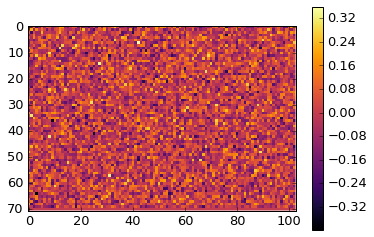

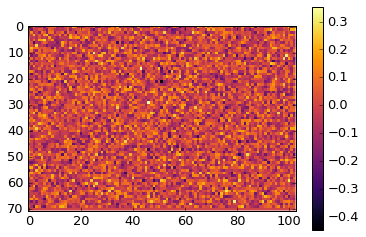

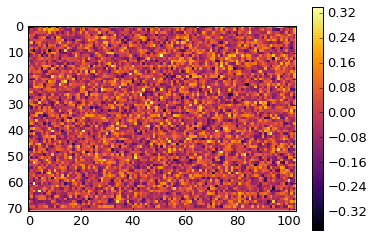

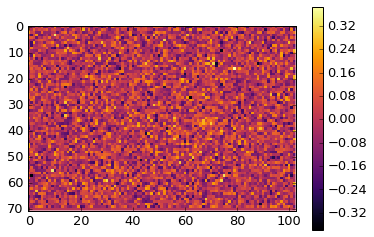

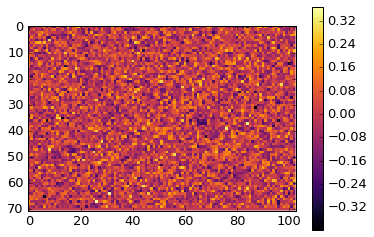

In [6]:
model = result.get_model(combine=True)
for i in range(len(model)):
    plt.imshow(result.img[i]-model[i])
    plt.colorbar()
    plt.show()

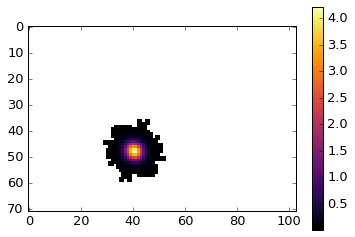

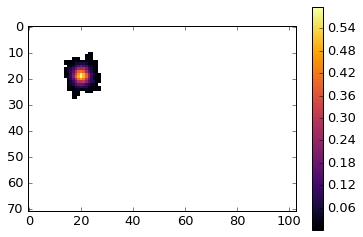

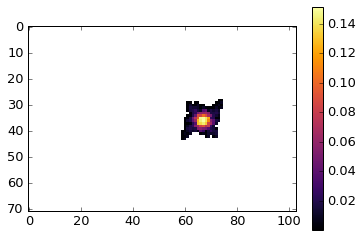

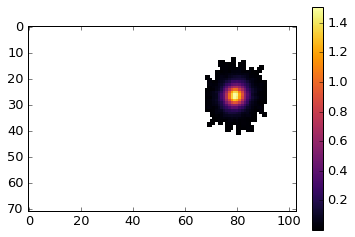

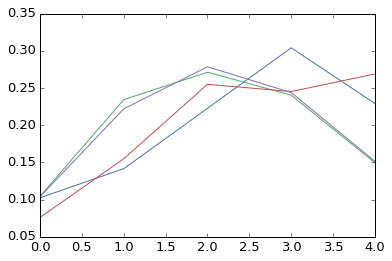

In [7]:
A, S, Gamma = result.A, result.S, result.T.Gamma
for k in range(len(S)):
    model = deblender.nmf.get_peak_model(A, S, Gamma, shape=(S[k].shape), k=k)[0]
    plt.imshow(np.ma.array(model, mask=model==0))
    plt.colorbar()
    plt.show()
for k in range(A.shape[1]):
    plt.plot(A[:,k])
plt.show()

In [8]:
result = deblender.nmf.deblend(
    img, peaks=img_peaks,
    constraints=["S", "S", "S", "S"],
    weights=weights,
    psf=None,
    max_iter=1000,
    e_rel=1e-3,
    psf_thresh=3e-3,
    l0_thresh=5e-4,
    traceback=False,
    monotonicUseNearest=True,
    fit_positions=False,
    prox_S=prox_S
)

INFO:proxmin.algorithms:Completed 244 iterations


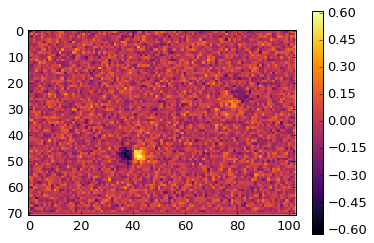

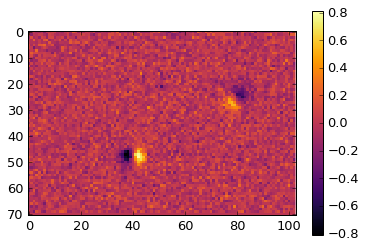

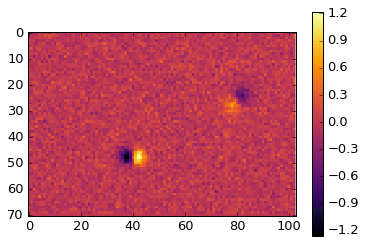

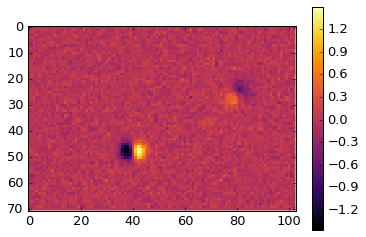

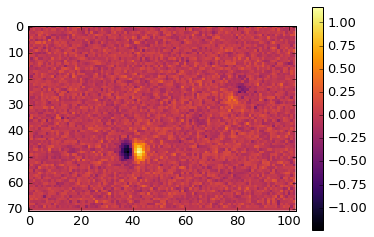

In [9]:
model = result.get_model(combine=True)
for i in range(len(model)):
    plt.imshow(result.img[i]-model[i])
    plt.colorbar()
    plt.show()

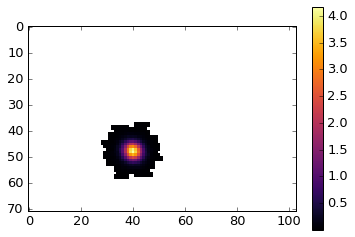

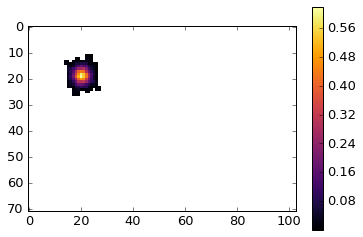

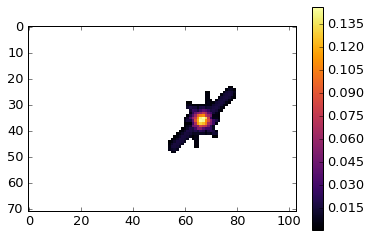

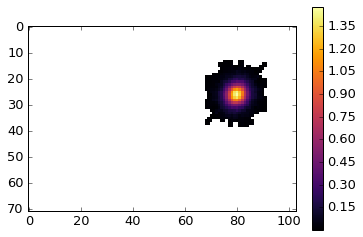

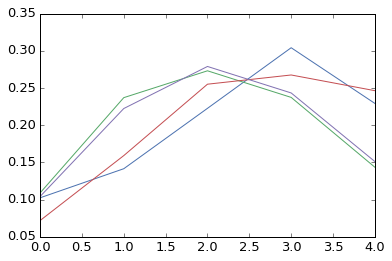

In [10]:
A, S, Gamma = result.A, result.S, result.T.Gamma
for k in range(len(S)):
    model = deblender.nmf.get_peak_model(A, S, Gamma, shape=(S[k].shape), k=k)[0]
    plt.imshow(np.ma.array(model, mask=model==0))
    plt.colorbar()
    plt.show()
for k in range(A.shape[1]):
    plt.plot(A[:,k])
plt.show()